In [6]:
%matplotlib notebook
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    
    from game import Game
    from data_preprocess import get_data_points
    from utils import get_feature_extractor_model, get_features, message_to_image, message_to_image_sm
    from agents import get_agents
    
    import numpy as np
    import matplotlib.pyplot as plt

In [7]:

sender_type = "aware"

n_all_features = 512

n_clusters = 10
n_samples = 3
n_vocab = 3
max_len = 2

img_dim = 10
img_rows = 105
img_cols = 105
img_features_len = 32
n_batches = 32
n_epochs = 10000000
action_size = 6
num_actions = 10

ppo_config = "configs/ppo-big-200.json"
network_config = "configs/mlp3_network-200.json"
data_csv_path = "data_csvs/cifar_feats.csv"
feat_model_path = 'feature_extractors/feature_model.h5'
feature_model_json_path = 'feature_extractors/feature_model.json'

flip_s = False
flip_l = False
freq = 1
debug = True

In [8]:
# Get data, prepare Agents, get feature extractor, initialize logging, create game pool
X1, Y1, n_features = get_data_points(data_csv_path, n_all_features)
Speaker, Listener = get_agents(ppo_config, network_config, sender_type, n_features, img_dim, img_features_len, n_samples, action_size)
intermediate_layer_model = get_feature_extractor_model(feat_model_path, feature_model_json_path)

big_rewards = []
data = []
game_pool = []

for i in range(n_batches):
    game_pool.append(Game(n_features, n_clusters, n_samples, n_vocab, sender_type, [X1, Y1]))




PCA components 0.95
X shape: (1000, 10), Y shape: (1000,)
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


<IPython.core.display.Javascript object>


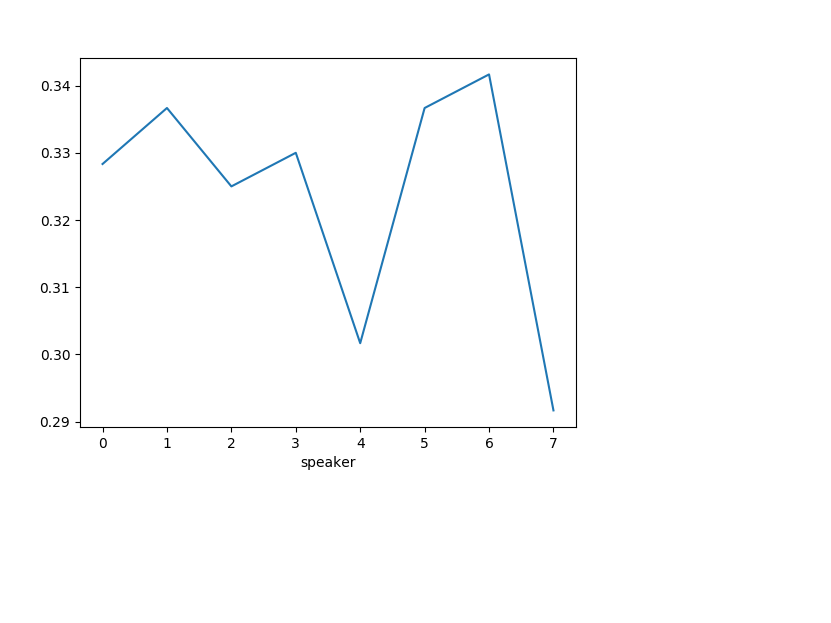

 message:  [5 1 6 4 1 3]  output:  0  epoch no:  0  avg reward 0.15625
 epoch no:  0  avg reward 0.15625
 message:  [7 1 0 1 2 3]  output:  0  epoch no:  100  avg reward 0.3283333333333333
 epoch no:  100  avg reward 0.3283333333333333
 message:  [4 7 0 1 4 3]  output:  0  epoch no:  200  avg reward 0.33666666666666667
 epoch no:  200  avg reward 0.33666666666666667
 message:  [1 5 3 7 1 7]  output:  0  epoch no:  300  avg reward 0.325
 epoch no:  300  avg reward 0.325
 message:  [0 1 1 3 5 8]  output:  1  epoch no:  400  avg reward 0.33
 epoch no:  400  avg reward 0.33
 message:  [2 9 0 7 7 0]  output:  0  epoch no:  500  avg reward 0.3016666666666667
 epoch no:  500  avg reward 0.3016666666666667
 message:  [2 7 3 6 2 1]  output:  2  epoch no:  600  avg reward 0.33666666666666667
 epoch no:  600  avg reward 0.33666666666666667
 message:  [2 4 3 7 8 8]  output:  2  epoch no:  700  avg reward 0.3416666666666667
 epoch no:  700  avg reward 0.3416666666666667
 message:  [2 6 0 7 4 3]  ou

KeyboardInterrupt: 

In [9]:

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()
for i in range(n_epochs):

    message_batch = []
    img_batch = []
    r = i%(2*freq)
    if r<1*freq:
        flip_s = False
        flip_l = True
    if r>=1*freq:
        flip_s = True
        flip_l = False
    l_rewards = []
    strokes = []
    for b in range(n_batches):
        strokes = []
        for idx in range(2):
            if idx ==0:
                feat = np.zeros((10,10), np.uint8)
            else:
                im = message_to_image_sm(strokes, img_dim, img_dim)
#                 feat = get_features([im])[0]
                feat = im.flatten()
            message = Speaker.act(states= game_pool[b].speaker_input(feat), independent=flip_s)  # (scalar between 0 and 4)
            message_batch.append(message)
            strokes.append(message)
        img = message_to_image(strokes, img_rows, img_cols)
        img_batch.append(img)
#         Speaker.reset()

    features_batch = get_features(intermediate_layer_model, img_batch)

    out_batch = []
    reward_batch = []
    for b in range(n_batches):
        out = Listener.act(states = game_pool[b].listener_input(features_batch[b]), independent = flip_l)
        out_batch.append(out)
        rew = game_pool[b].reward(out)
        reward_batch.append(rew)
        game_pool[b].reset()
    speaker_terminals = []
    rew_speaker = []
    for rew in reward_batch:
        speaker_terminals.extend([False, True])
        rew_speaker.extend([0, rew])

    if not flip_s:
#         print('e1')
        e1 = Speaker.model.observe(reward=rew_speaker, terminal=speaker_terminals)
    if not flip_l:
#         print('e2')
        e2 = Listener.model.observe(reward=reward_batch, terminal=[True]*n_batches)
#     assert e1 == e2
#     e = e1
    big_rewards.extend(reward_batch)
    big_rewards = big_rewards[-600:]
    if i%(100)==0:
#         print(" output: ", out)
        avg_rew = sum(big_rewards)/len(big_rewards)
        print(" message: ", message, " output: ", out, " epoch no: ", i, " avg reward", avg_rew)
        print(" epoch no: ", i, " avg reward", avg_rew)

        if(i!=0):
            data.append(avg_rew)
        ax.clear()
        ax.plot(data)
        if not flip_s:
            ax.set_xlabel('speaker')
        else:
            ax.set_xlabel('listener')
        fig.canvas.draw()


#     if sum(big_rewards)/len(big_rewards)>.75:
#         break
